In [1]:
import os
import MDAnalysis as md
import h5py
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from scipy import ndimage

def bin_plane(xyz, plane_size, L, num_bins, detector_eff=1.0, axis=1):
    if detector_eff > 1.0:
        raise ValueError("Detector efficiency cannot be over 100%.")
    
    # Create the grid
    grid_range = np.linspace(-plane_size / 2, plane_size / 2, num_bins)
    
    if axis == 0:
        grid = np.array([(-L, x, y) for y in grid_range for x in grid_range], dtype=np.float32)
        B1 = 1
        B2 = 2
    elif axis == 1:
        grid = np.array([(x, -L, y) for y in grid_range for x in grid_range], dtype=np.float32)
        B1 = 0
        B2 = 2
    elif axis == 2:
        grid = np.array([(x, y, -L) for y in grid_range for x in grid_range], dtype=np.float32)
        B1 = 1
        B2 = 0
    else:
        raise ValueError("Invalid axis value. Axis must be 0, 1, or 2.")
    
    # Filter out points that will never hit the plane based on their y-coordinate and the plane's location
    if L > 0:
        xyz = xyz[xyz[:, axis] < 0.0]  # Points above the plane when L > 0 will not hit
    elif L < 0:
        xyz = xyz[xyz[:, axis] > 0.0]  # Points below the plane when L < 0 will not hit

    # Calculate the hit locations on the plane
    k = -L / xyz[:, axis]
    hit_location = k[:, np.newaxis] * xyz

    # Initialize the bins
    bins = np.zeros((num_bins, num_bins), dtype=int)

    N = len(hit_location)
    M = int(detector_eff * N)
    
    keep_idx = np.random.choice(N, M, replace=False)
    hit_location = hit_location[keep_idx]

    # Process each hit location
    for hit in hit_location:
        # Check if the hit is within the plane bounds
        if -plane_size / 2 <= hit[B1] <= plane_size / 2 and -plane_size / 2 <= hit[B2] <= plane_size / 2:
            # Find the closest grid point for the hit location
            distance = scipy.spatial.distance.cdist([hit], grid)
            closest_bin = np.argmin(distance)

            # Convert the linear index to 2D index and increment the corresponding bin
            y_idx, x_idx = divmod(closest_bin, num_bins)
            bins[y_idx, x_idx] += 1

    return bins.astype(np.int16)

In [2]:
if __name__ == "__main__":
    # Name of the project folder 
    cpath = 'ubi48_static'

    # Where is the folder inside?
    cwd = '/home/simon/results/last_frame/600ev'
    cwd = f"{cwd}/{cpath}"
    os.chdir(cwd)
    
    # Define the detector parameters
    num_bins = 20
    plane_size = 100
    detector_distance = 10
    detector_eff = 1.0

    # Which axis should the detector be placed on? (x=0, y=1, z=2)
    axis = 1

    # This value will be used to calculate how many simulations are in the data.h5-file (do not change)
    number_simulations = 0

In [3]:
imgs = []

# Open the data-file
with h5py.File('data.h5', 'r') as sims:
        
        # Here we check to see how many simulations there are
        for sim in range(len(sims)):
            number_simulations += 1

        # for evert simulation ...
        for i in range(number_simulations):
            current_sim = sims[f"sim{i+1}"]

            # load the positional data ...
            pos_data = np.array(current_sim['unit_displacement'])

            # and use it to calculate the explosion pattern
            img = np.ndarray(shape=(int(num_bins),int(num_bins)))
            img = bin_plane(pos_data,plane_size,detector_distance,num_bins,detector_eff,axis)
            imgs.append(img)

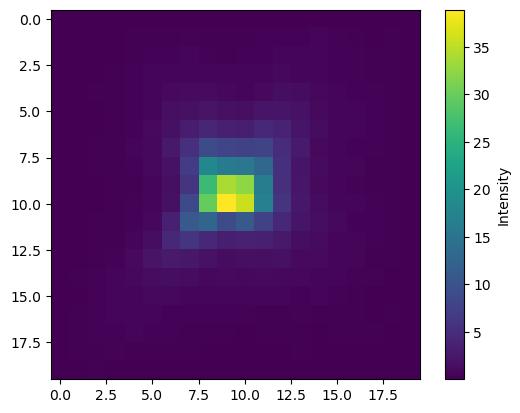

In [4]:
# This will output the averaged explosion pattern across all simulations
average_img = sum(imgs) / len(imgs)
fig = plt.figure()
plt.imshow(average_img)
plt.colorbar(label = "Intensity")

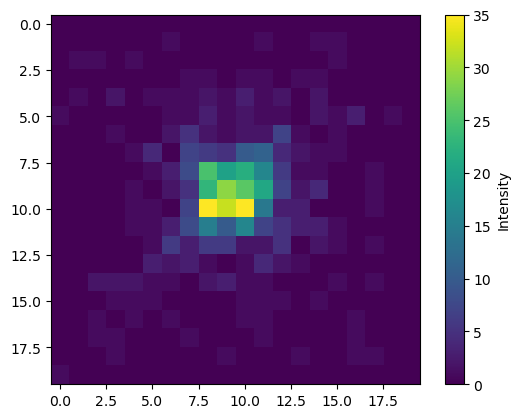

In [5]:
# Here we can check a specific explosion pattern
simulation_number = 90
fig = plt.figure()
plt.imshow(imgs[simulation_number])
plt.colorbar(label = "Intensity")